In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from datetime import datetime, timedelta
from tensorflow.keras.layers import LSTM, Dense
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import yfinance as yf

In [40]:
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [41]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append((seq, label))
    return np.array(sequences)


In [42]:
def build_tunable_lstm_model(hp, sequence_length):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units', min_value=50, max_value=200, step=50),
                   input_shape=(sequence_length, 1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                    activation='relu'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [43]:
lambda hp: build_tunable_lstm_model(hp, sequence_length)


<function __main__.<lambda>(hp)>

In [46]:
def tune_hyperparameters_tuner(train_data, val_data, sequence_length):
    tuner = RandomSearch(
        lambda hp: build_tunable_lstm_model(hp, sequence_length),
        objective='val_loss',
        
        max_trials=10,
        directory='keras_tuner_dir',
        project_name='stock_price_prediction')

    tuner.search(train_data[0], train_data[1],
                 epochs=50,
                 batch_size=32,
                 validation_data=val_data,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    best_model = tuner.get_best_models(num_models=1)[0]
    best_mse = best_model.evaluate(val_data[0], val_data[1])
    return best_model, best_mse


In [47]:
def generate_dates(start_date, end_date, sequence_length):
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    predicted_dates = [end_date + timedelta(days=i) for i in range(1, sequence_length + 1)]
    return predicted_dates


In [48]:
def predict_stock_prices(model, test_data):
    predictions = model.predict(test_data)
    return predictions


In [49]:
def evaluate_model(ticker, start_date, end_date):
    # Download stock data
    stock_data = download_stock_data(ticker, start_date, end_date)

    # Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

    # Create sequences
    sequence_length = 10
    sequences = create_sequences(scaled_data, sequence_length)

    # Split data into train and validation sets
    train_size = int(len(sequences) * 0.8)
    train_data = sequences[:train_size]
    val_data = sequences[train_size:]
    train_X, train_y = zip(*train_data)
    val_X, val_y = zip(*val_data)

    train_X = np.array(train_X)
    train_y = np.array(train_y)
    val_X = np.array(val_X)
    val_y = np.array(val_y)

    # Reshape the data
    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
    val_X = np.reshape(val_X, (val_X.shape[0], val_X.shape[1], 1))

    # Hyperparameter tuning
    lstm_units_list = [50, 80]
    dense_units_list = [32, 64]
    learning_rate_list = [0.001, 0.01]

    best_model, _ = tune_hyperparameters_tuner((train_X, train_y), (val_X, val_y), sequence_length)

    # Test the model
    test_data = sequences[train_size - sequence_length:]
    test_X, test_y = zip(*test_data)
    test_X = np.array(test_X)
    test_y = np.array(test_y)

    # Reshape the data
    test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

    predictions = predict_stock_prices(best_model, test_X)

    # Inverse transform the predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    actual_values = scaler.inverse_transform(np.array(test_y).reshape(-1, 1))

    # Only keep the relevant part of actual_values
    actual_values = actual_values[:len(predictions)]

    return actual_values, predictions, generate_dates(end_date, end_date, sequence_length)
   


In [50]:
if __name__ == "__main__":
    ticker = input("Enter the stock ticker: ")
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    end_date = input("Enter the end date (YYYY-MM-DD): ")

    actual_values, predictions, predicted_dates = evaluate_model(ticker, start_date, end_date)

    print("Predicted Values")
    print()
    print("Predicted Dates:", predicted_dates)
    print("Predictions:", predictions.flatten())


Enter the stock ticker: GOOGL
Enter the start date (YYYY-MM-DD): 2020-01-01
Enter the end date (YYYY-MM-DD): 2024-02-02
[*********************100%***********************]  1 of 1 completed
Reloading Tuner from keras_tuner_dir\stock_price_prediction\tuner0.json


C:\Users\D\AppData\Local\Temp\ipykernel_9436\1077509186.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


7/7 [==============================] - 0s 7ms/step
Predicted Values

Predicted Dates: [datetime.datetime(2024, 2, 3, 0, 0), datetime.datetime(2024, 2, 4, 0, 0), datetime.datetime(2024, 2, 5, 0, 0), datetime.datetime(2024, 2, 6, 0, 0), datetime.datetime(2024, 2, 7, 0, 0), datetime.datetime(2024, 2, 8, 0, 0), datetime.datetime(2024, 2, 9, 0, 0), datetime.datetime(2024, 2, 10, 0, 0), datetime.datetime(2024, 2, 11, 0, 0), datetime.datetime(2024, 2, 12, 0, 0)]
Predictions: [103.544266 101.886765 101.594604 101.268265 103.08702  104.249985
 104.8418   104.81608  107.26107  106.93991  106.00798  105.15815
 106.76066  108.35386  107.05661  105.46964  104.69053  105.23441
 105.570366 106.07775  104.83706  104.24152  106.617386 107.35604
 107.48024  106.22152  105.771225 105.17015  105.580124 107.2377
 107.60116  110.48714  114.61437  116.6812   116.61989  118.41856
 119.964264 121.83178  122.45078  124.155716 123.1346   121.64194
 122.89521  124.20097  124.046844 123.4077   123.75084  124.52676

In [51]:
print("Stock Name:", ticker)
print("Actual Values:", actual_values.flatten())
print()
print("***************************************************************")
print()
print("Predicted Values")
print()
print("Predicted Dates:", predicted_dates)
print("Predictions:", predictions.flatten())

last_prediction = predictions[-1][0]
print()

print()
print("Prdiction Date",end_date)
print("Predicted Price ",last_prediction)

Stock Name: GOOGL
Actual Values: [101.02999878 101.38999939 100.88999939 103.73000336 104.36000061
 104.72000122 104.47000122 108.41999817 106.44000244 105.34999847
 104.63999939 107.43000031 108.87000275 105.97000122 104.5
 104.18000031 105.29000092 105.41000366 105.97000122 103.84999847
 103.70999908 107.58999634 107.33999634 107.19999695 105.31999969
 105.41000366 104.69000244 105.56999969 107.76999664 107.34999847
 111.75       116.56999969 117.51000214 116.51000214 119.51000214
 120.83999634 122.83000183 122.76000214 125.05000305 122.55999756
 120.90000153 123.48000336 124.61000061 123.66999817 122.87000275
 123.72000122 124.66999817 126.01000214 127.30999756 122.5
 122.13999939 122.23000336 123.63999939 123.83000183 123.66999817
 125.08999634 123.52999878 123.09999847 120.55000305 123.15000153
 122.33999634 118.33999634 118.33000183 120.18000031 119.09999847
 119.69999695 119.90000153 121.75       120.11000061 119.48000336
 116.44999695 117.13999939 118.93000031 124.54000092 125.

In [52]:
from sklearn.metrics import mean_squared_error

def evaluate_model_mse(actual_values, predictions):
    mse = mean_squared_error(actual_values, predictions)
    return mse

# Example usage
# Assuming actual_values and predictions are available
mse = evaluate_model_mse(actual_values, predictions)
print(f'Mean Squared Error (MSE): {mse}')


Mean Squared Error (MSE): 5.528227983723134


In [57]:
def plot_results(actual_values, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(actual_values, label='Actual Prices', color='blue', marker='o')
    plt.plot(predictions, label='Predicted Prices', color='red', marker='o')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()


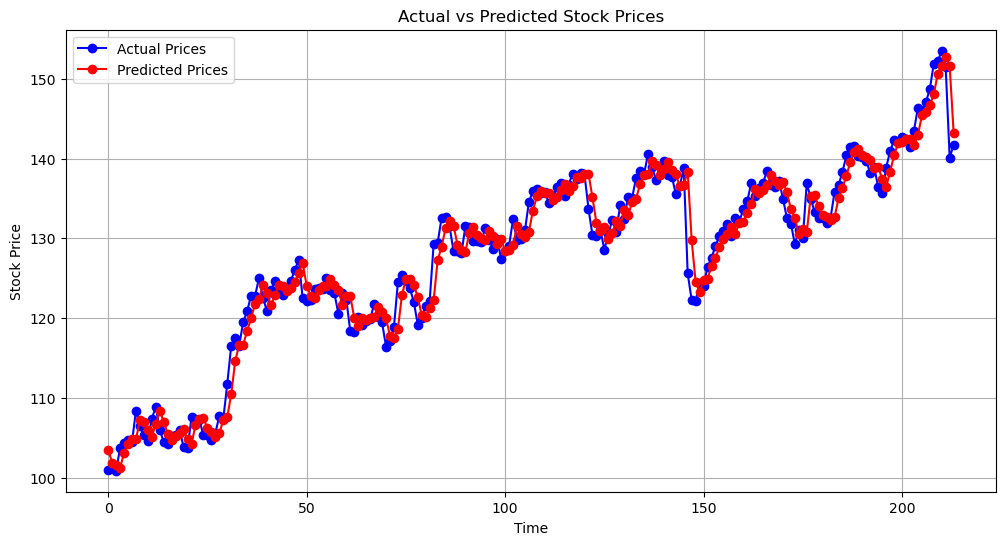

In [58]:
plot_results(actual_values, predictions)